In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
import timm

warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

def set_seed(seed=0):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    
set_seed(7777)

In [2]:
import pretrainedmodels

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device를 cuda로 설정
print(device)

cuda


### Data overview

In [4]:
train_df = pd.read_csv("train.csv")
# train_df = train_df[train_df['Id'] != 'new_whale']
# train_df.reset_index(drop=True)

For train data we have a DataFrame with image names and ids. And of course for train and test we have images in separate folders.

In [5]:
print(f"There are {len(os.listdir('train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


25k images in train and 5k different whales!
Let's have a look at them

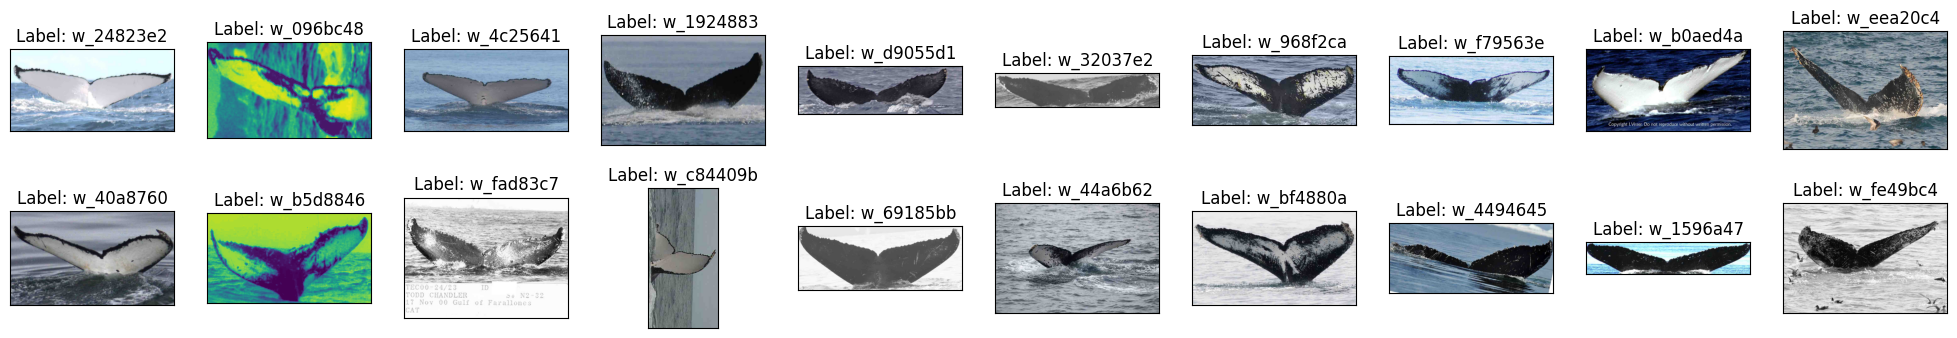

In [6]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [7]:
train_df.Id.value_counts()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
            ... 
w_6f504c0      1
w_2fdee7b      1
w_a0838d1      1
w_3698eaf      1
w_b9bfd4e      1
Name: Id, Length: 4251, dtype: int64

In [8]:
len(train_df['Id'].unique())

4251

In [9]:
train_df[train_df['Id'] == 'new_whale']

,Image,Id
7,0031c258.jpg,new_whale
19,007c3603.jpg,new_whale
20,00863b8c.jpg,new_whale
26,00aa021c.jpg,new_whale
30,00ad9219.jpg,new_whale
...,...,...
9794,fe9264a2.jpg,new_whale
9802,feb1ecd3.jpg,new_whale
9820,ff2d0d82.jpg,new_whale
9837,ffb71ac2.jpg,new_whale


In [10]:
train_df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


In [11]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


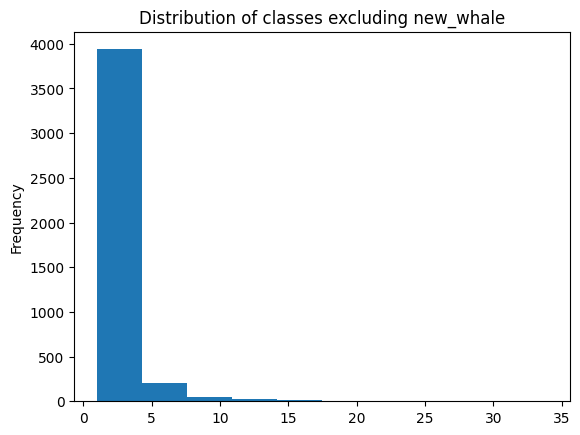

In [12]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

We can see that there is a huge disbalance in the data. There are many classes with only one or several samples , some classes have 50+ samples and "default" class has almost 10k samples.

## Dataset

Now we need to create a dataset. Sadly, default version won't work, as images for each class are supposed to be in separate folders. So I write a custom WhaleDataset.

In [13]:
from itertools import combinations
import random

class TripletGenerator:
    def __init__(self, file_class_mapping):
        self.file_class_mapping = file_class_mapping
        self.class_to_files = defaultdict(list)

        for file, class_ in file_class_mapping.items():
            self.class_to_files[class_].append(file)

        self.classes = list(self.class_to_files.keys())

    def get_triplet(self):
        # 양성 클래스 선택
        pos_class = random.choice(self.classes)
        pos_files = self.class_to_files[pos_class]

        # 앵커와 긍정적 예시 선택
        if len(pos_files) > 1:
            anchor, positive = random.sample(pos_files, 2)
        else:
            anchor = positive = pos_files[0]

        # 부정적 예시 선택
        neg_class = random.choice([cls for cls in self.classes if cls != pos_class])
        negative = random.choice(self.class_to_files[neg_class])

        return anchor, positive, negative

In [14]:
class TripletWhaleDataset(Dataset):
    def __init__(self, datafolder, df, triplet_gen, transform=None):
        self.datafolder = datafolder
        self.df = df.values
        self.triplet_gen = triplet_gen
        self.transform = transform

    def __len__(self):
        # 임의로 길이를 설정하거나 실제 데이터셋 크기에 맞게 조정
        return len(self.df)

    def __getitem__(self, idx):
        anchor_path, positive_path, negative_path = self.triplet_gen.get_triplet()
        anchor = self.read_image(anchor_path)
        positive = self.read_image(positive_path)
        negative = self.read_image(negative_path)

        return anchor, positive, negative

    def read_image(self, path):
        img_name = os.path.join(self.datafolder, path)
        image = np.array(Image.open(img_name).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image

In [15]:
data_transforms = A.Compose([
                            A.Resize(256, 256),
                            A.HorizontalFlip(p=0.5),
                            # A.Affine(scale=(0.9, 1.1), translate_percent=(0.01, 0.01), rotate=(0, 0), shear=(-0.5, 0.5), interpolation=1, p=1),  # 어파인 변환
                            A.Rotate(limit=25, p=0.5),
                            A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                            A.ToGray(p=0.5),
                            ToTensorV2()                            
])

data_transforms_test = A.Compose([
                                   A.Resize(256, 256),
                                   A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                                   # A.ToGray(p=1),
                                   ToTensorV2()
])

In [16]:
file_class_mapping = {row['Image']: row['Id'] for index, row in train_df.iterrows()}

In [17]:
triplet_gen = TripletGenerator(file_class_mapping)
dataset = TripletWhaleDataset('train/', train_df, triplet_gen, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
def imshow(img):
    MEAN = np.array([0.485])
    STD = np.array([0.229])
    img = img * STD[0] + MEAN[0]   # 시각화 위해 unnormalize 해주기
    plt.imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1)) # imshow 위해 형변환 하여 시각화

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


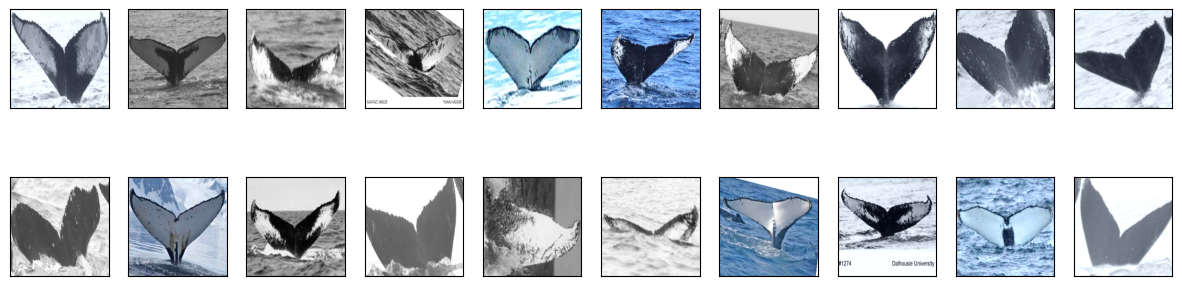

In [19]:
data, label,_ = next(iter(dataloader))
print(data.shape, label.shape)

fig = plt.figure(figsize=(15, 4))
data = data.numpy()
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(data[idx])

## Initializing model

We need to define model, loss, oprimizer and possibly a scheduler.

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TripletModel(nn.Module):
    def __init__(self):
        super(TripletModel, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_model.fc.in_features, 50)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return nn.functional.normalize(x, p=2, dim=1)

In [21]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)
    losses = torch.relu(distance_positive - distance_negative + margin)
    return losses.mean()

model = TripletModel().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
# exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, min_lr=1e-6)

C:\Users\MMC_JYB\anaconda3\envs\yb\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MMC_JYB\anaconda3\envs\yb\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def train(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch+1}/{epochs}')
        for i, data in progress_bar:
            # 여기에 Triplet 데이터 로딩 로직 추가 필요
            anchor, positive, negative = data
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = triplet_loss(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.8f}")
        torch.save(model, f'model_triplet.pth')
        
train(model, dataloader, 20)

Epoch 1/20: 100%|██████████| 308/308 [09:49<00:00,  1.91s/it, loss=0.478]


Epoch 1, Loss: 0.47771979


Epoch 2/20: 100%|██████████| 308/308 [09:49<00:00,  1.91s/it, loss=0.419]


Epoch 2, Loss: 0.41883408


Epoch 3/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.376]


Epoch 3, Loss: 0.37594590


Epoch 4/20: 100%|██████████| 308/308 [09:47<00:00,  1.91s/it, loss=0.356]


Epoch 4, Loss: 0.35632806


Epoch 5/20: 100%|██████████| 308/308 [09:47<00:00,  1.91s/it, loss=0.346]


Epoch 5, Loss: 0.34566878


Epoch 6/20: 100%|██████████| 308/308 [09:47<00:00,  1.91s/it, loss=0.336]


Epoch 6, Loss: 0.33638399


Epoch 7/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.374]


Epoch 7, Loss: 0.37366533


Epoch 8/20: 100%|██████████| 308/308 [09:49<00:00,  1.91s/it, loss=0.305]


Epoch 8, Loss: 0.30496847


Epoch 9/20: 100%|██████████| 308/308 [09:49<00:00,  1.91s/it, loss=0.289]


Epoch 9, Loss: 0.28903535


Epoch 10/20: 100%|██████████| 308/308 [09:49<00:00,  1.91s/it, loss=0.276]


Epoch 10, Loss: 0.27649236


Epoch 11/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.262]


Epoch 11, Loss: 0.26208051


Epoch 12/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.257]


Epoch 12, Loss: 0.25690962


Epoch 13/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.236]


Epoch 13, Loss: 0.23569096


Epoch 14/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.236]


Epoch 14, Loss: 0.23584209


Epoch 15/20: 100%|██████████| 308/308 [09:47<00:00,  1.91s/it, loss=0.24] 


Epoch 15, Loss: 0.24021831


Epoch 16/20: 100%|██████████| 308/308 [09:47<00:00,  1.91s/it, loss=0.236]


Epoch 16, Loss: 0.23635458


Epoch 17/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.233]


Epoch 17, Loss: 0.23323560


Epoch 18/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.229]


Epoch 18, Loss: 0.22936620


Epoch 19/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.219]


Epoch 19, Loss: 0.21877788


Epoch 20/20: 100%|██████████| 308/308 [09:48<00:00,  1.91s/it, loss=0.223]

Epoch 20, Loss: 0.22322334


## Inference

In [ ]:
# model_conv.load_state_dict(torch.load('model_5.pth'))

In [31]:
class CustomDataset(Dataset):
    def __init__(self, datafolder, transform=None):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = np.array(Image.open(img_name).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, self.image_files_list[idx]

train_dataset = CustomDataset('train/', transform=data_transforms)
test_dataset = CustomDataset('test/', transform=data_transforms_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    file_names = []
    with torch.no_grad():
        for imgs, fpaths in tqdm.tqdm(dataloader):
            imgs = imgs.to(device)
            emb = model(imgs)
            embeddings.append(emb.cpu().numpy())
            file_names.extend(fpaths)
    return np.concatenate(embeddings), file_names

# 임베딩 추출
train_embeddings, train_fnames = extract_embeddings(train_loader, model)
test_embeddings, test_fnames = extract_embeddings(test_loader, model)

100%|██████████| 488/488 [05:53<00:00,  1.38it/s]


In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import os

# NearestNeighbors 인스턴스 생성 및 학습
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_embeddings)

# 테스트 데이터에 대한 가장 가까운 이웃 찾기
distances_test, neighbors_test = neigh.kneighbors(test_embeddings)

# file_id_mapping은 데이터셋의 이미지 파일 이름과 ID를 매핑하는 딕셔너리
file_id_mapping = {k: v for k, v in zip(train_df.Image.values, train_df.Id.values)}

# 예측 결과 생성
preds_str = []
for fpath, (distances, neighbors) in zip(test_fnames, zip(distances_test, neighbors_test)):
    sample_result = []
    sample_classes = []
    for d, n in zip(distances, neighbors):
        train_file = os.path.basename(train_fnames[n])
        class_train = file_id_mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))

    if "new_whale" not in sample_classes:
        sample_result.append(("new_whale", 0.1))
    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

# 결과를 DataFrame으로 변환 및 저장
df = pd.DataFrame({'Image': [os.path.basename(f) for f in test_fnames], 'Id': preds_str})
df.to_csv("hehehehehe.csv", index=False)